# Predicting Tanzanian Well Status

In [69]:
# imports we need for the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Business Understanding

   Water scarcity is quickly becoming one of the most pressing issues of the 21st century. This scarcity can be caused by an absolute lack of water, by a lack of infrastructure needed to provide safe drinking water, or a plethora of other reasons. No matter the cause of this water scarcity, figuring out where these water scarcity problems are likely to arise and the factors causing this scarcity will be a large step in solving the water crisis. 
   
   I have looked specifically at waterpoints in Tanzania to create this predictive model. Tanzania, like many countries in Africa, suffers from extreme water scarcity. Of the 58 million people in Tanzania, 4 million lack access to safe drinking water, 29 million don't have access to adequate amounts of sanitary water for cleaning, cooking, or a host of other reasons. However, Tanzania is somewhat uniquely poised to respond to the insights provided by this model. The Tanzanian market for water supply and sanitation technologies is particularly responsive to innovations. Furthermore, Tanzania has a growing digital financial sector which can be utilized in tandem with many of the microloan services that are gaining traction. These financial resources could provide the capital to maximize the impact of water infrastructure built and provide help ensure proper maintenance of these waterpoints.
   
   The data used to create this predictive model was collected by Tanzanian Ministry of Water and aggregated by the open source platform Taarifa; they aggregate different sorts of infrastructure data from countries around the world. This data can also be easily accessed from the DrivenData.org website that hosts a variety of data science competitions, datasets, and more. 

In [70]:
# change display to show all columns of the dataframe
pd.set_option('display.max_columns', None)

In [71]:
# here we have the features provided to us
X = pd.read_csv('data/TrainingFeatures.csv', parse_dates=[2])
X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [72]:
# and the target values with matching index and id
y = pd.read_csv('data/TrainingLabels.csv')
y.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


## Data Exploration

This dataframe actually doesn't have to high of a proportion of missing values. There were a few standout features that will need to either be dropped or imputed. At first, this doesn't look too bad, but upon further inspection, there are several problems with this data that made it tricky to clean effectively. The feature with the most missing values is `scheme_name`, which makes sense as most of the waterpoints are not named. 

In [73]:
# the data is mostly clean, but some variables do have several missing values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   amount_tsh             59400 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 55765 non-null  object        
 4   gps_height             59400 non-null  int64         
 5   installer              55745 non-null  object        
 6   longitude              59400 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   wpt_name               59400 non-null  object        
 9   num_private            59400 non-null  int64         
 10  basin                  59400 non-null  object        
 11  subvillage             59029 non-null  object        
 12  region                 59400 non-null  object        
 13  r

### Summary Stats

Looking at the describe dataframe makes many of these numerical values show their problems. For example, the 75th percentile for `amount_tsh` is still only 20 (presumably) meters, but the max is 350,000 meters. To give some context, the radius of the earth is only about 6,371,000 meters. Several of these variables show an outsized amount of zeroes. Even categorical variables have zeroes in this dataset. It is clear that instead of entering the data with nulls when the data was missing, zeroes were used in their stead. 

Thankfully, the categorical variables actually have nulls instead of zeroes. However, there are still plenty of problems as many of the values (including missing values) are not consistently recorded. The `wpt_name` variable used the category "none" for missing names, while the `scheme_name` variable actually entered the values as nulls. Furthermore, many of the features have way too many different variables to be viable for OneHotEncoding without putting a severe strain on computer and hours of computation. Also, many of the features contain the exact same information as other features. Understanding what is going on with many of these variables would be much easier if there was more documentation on what each variable is and how it was collected.

In [74]:
# looking at the summary statistics of numeric variables
X.describe(datetime_is_numeric=True)

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,2012-03-29 09:11:33.818181888,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
min,0.000000,0.000000,2002-10-14 00:00:00,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,2011-04-01 00:00:00,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,2012-10-10 00:00:00,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,2013-02-09 00:00:00,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2013-12-03 00:00:00,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000
std,21453.128371,2997.574558,NaN,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547


#### Numeric variables
- id: identifying variable unique to every waterwell
- amount_tsh: Total static head is the vertical distance between the water source and the head of the pump
    - distance is zero for the vast majority of wells
- date_recorded: The day the data from the well was recorded
    - seems the vast majority of the dates were in the early 2010's
    - there are a few outliers in the early 2000's
- gps_height: The altitude of the well
    - seems that most wells were quite low in elevation, despite much of Tanzania being the high desert
    - well over half of the values are zero
- longitude: The longitudinal coordinate of the well
    - some of the values here are zero, which doesn't make sense given Tanzania's location
- latitude: The lattitudinal coordinate of the well
- num_private: Could not find what num_private means anywhere
    - good candidate feature to be dropped
- region_code: Contains some sort of geographic data
    - there are 21 different regions, but 27 different region_codes
- district_code: Contains some sort of geographic data
    - starts out at 0 and goes to 99
- population: Described as population around the well
    - not exactly sure what this means
    - regardless, most wells have very low numbers
    - all those zeroes could be missing values or reflective of what "around the well" means
- construction_year: The year that the well was built
    - all the zeroes are missing values here, will need to clean it up

In [75]:
# looked at all the categorical variables
X.describe(include='object')

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,55765,55745,59400,59400,59029,59400,59400,59400,56066,59400,55523,31234,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,1897,2145,37400,9,19287,21,125,2092,2,1,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625


#### Categorical variables
- funder: The name of the party that funded the well
- installer: The name of the party that installed the well
- wpt_name: The name of the waterpoint
    - a good candidate for dropping
- basin: The name of the basin that the well's water drains to
- subvillage: Contains some sort of geographic data
    - extremely granular data, almost 20,000 unique values
    - will need to either drop or transform data
- region: Contains some sort of geographic data
- lga: Contains some sort of geographic data
    - local government authority
- ward: Contains some sort of geographic data
    - probably a better candidate for analysis than subvillage
- public_meeting: not sure what this point means
    - presumably just true if the well is used as a place of public meeting
- recorded_by: The party that recorded the data
    - literally only one category, should drop this feature
- scheme_management: Describes who operates the waterpoint
    - seems to classify the operators of the well by type of party
- scheme_name: Describes who operates the waterpoint
    - seems to give the name of the party
    - way more observations here, may want to
- permit: Is true if the waterpoint has a permit
- extraction_type: Describes the method of extraction used
    - 17 unique categories, but several don't have many observations
- extraction_type_group: Describes the method of extraction used
    - 13 unique categories, and each one has at least 98 observations
- extraction_type_class: Describes the method of extraction used
    - 7 unique categories, each one has enough observations but group has more granularity
- management: Describes the type of party that manages the well
    - 12 unique values, look at scheme_management
- management_group: Describes the type of party that manages the well
    - 5 uniqe values
- payment: Describes the cost of operating the well
    - No idea if cost for the users or for the operating party
- payment_group: Describes the cost of operating the well
    - Literally all the same values as payment, drop this column
- water_quality: Describes the quality of the water
    - may be worth combining salty abandoned and flouride abandoned into just abandoned
- quality_group: Describes the quality of the water
    - has significant overlap with water_quality, may just drop this feature
- quantity: Describes the quantity of water the well can provide
    - this feature almost seems like cheating, may have misunderstood the problem
- quantity_group: Describes the quantity of water the well can provide
    - once again a redundant feature with no new info, need to drop this feature
- source: Describes where the water comes from
- source_type: Describes where the water comes from
    - lots of redundancy between this feature and source
- source_class: Describes where the water comes from
- waterpoint_type: Describes the type of waterpoint
- waterpoint_type_group: Describes the type of waterpoint
    - need to drop either waterpoint type or waterpoint_type_group

## Data Cleaning

##### Scheme Name

In [76]:
# scheme_name is super messy with too many categories, best to drop it
X['scheme_name'].value_counts().head(20)

K                                        682
None                                     644
Borehole                                 546
Chalinze wate                            405
M                                        400
DANIDA                                   379
Government                               320
Ngana water supplied scheme              270
wanging'ombe water supply s              261
wanging'ombe supply scheme               234
Bagamoyo wate                            229
I                                        229
Uroki-Bomang'ombe water sup              209
N                                        204
Kirua kahe gravity water supply trust    193
Machumba estate pipe line                185
Makwale water supplied sche              166
Kijiji                                   161
S                                        154
Losaa-Kia water supply                   152
Name: scheme_name, dtype: int64

##### Payment

In [77]:
# the payment and payment_type features are identical, drop one of them
X['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [78]:
X['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

##### Water Quality

In [79]:
# The water_quality and quality_group features have a ton of overlap, drop quality group
X['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [80]:
X['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

##### Water Quantity

In [81]:
# No further information provided between quantity and quantity_group, drop one
X['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [82]:
X['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

##### Source

In [83]:
# tons of redundancy between source and source_type, drop source_type
X['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [84]:
X['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

##### Waterpoint Type

In [85]:
# Only one extra category for waterpoint_type, probably good to drop waterpoint_type_group
X['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [86]:
X['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

##### Extraction Type

In [87]:
# extraction_type, extraction_type_group, and extraction_type_class 
# all give the same information with different levels of granularity
X['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [88]:
X['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [89]:
X['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

##### Region

In [90]:
# There is conflicting information between region and region_code
X.groupby('region')['region_code'].value_counts()

region         region_code
Arusha         2              3024
               24              326
Dar es Salaam  7               805
Dodoma         1              2201
Iringa         11             5294
Kagera         18             3316
Kigoma         16             2816
Kilimanjaro    3              4379
Lindi          80             1238
               8               300
               18                8
Manyara        21             1583
Mara           20             1969
Mbeya          12             4639
Morogoro       5              4006
Mtwara         90              917
               99              423
               9               390
Mwanza         19             3047
               17               55
Pwani          6              1609
               60             1025
               40                1
Rukwa          15             1808
Ruvuma         10             2640
Shinyanga      17             4956
               14               20
               11           

##### Management

In [91]:
# scheme_management seems to describe something different from the other two management variables,
# but also seems to have high levels of multicollinearity. However, management seems to be a more granular 
# version of the management group variable.
X['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [92]:
X['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [93]:
X['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

##### Subvillage

In [94]:
# many of the subvillages with few observations won't be conducive to modeling
(X['subvillage'].value_counts() > 100).sum()

22

In [95]:
# it may be best just to drop the column given how the vast majority of subvillages will only have 1 well
X['subvillage'].value_counts().head(22)

Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
Sokoni        232
M             187
Muungano      172
Mbuyuni       164
Mlimani       152
Songambele    147
Msikitini     134
Miembeni      134
1             132
Kibaoni       114
Kanisani      111
Mapinduzi     109
I             109
Mjini         108
Mjimwema      108
Mkwajuni      104
Mwenge        102
Name: subvillage, dtype: int64

##### District Code

In [96]:
# district code seems really messy, it would have to be grouped by region
# may be better not to use this feature
X.groupby('region')['district_code'].value_counts()

region  district_code
Arusha  2                1206
        7                1009
        30                326
        6                 310
        5                 201
                         ... 
Tanga   5                 293
        8                 288
        6                 266
        7                 127
        4                 110
Name: district_code, Length: 132, dtype: int64

In [97]:
# look at the target
y.describe(include='object')

,status_group
count,59400
unique,3
top,functional
freq,32259


In [98]:
# and looked at the split up of the target
y['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

### Pre-split Cleaning

#### Feature Removal

First we should drop all the columns that are too messy or don't provide any further information. 
- The `num_private` feature has 0's for the vast majority of the columns and there is record of what this even means.
- The `recorded_by` feature is the same for every single well, and thus provides no meaningful information to our model.
- The `payment_type` variable is identical to the `payment` variable. The `quality_group` contains almost identical information to `water_quality`. 
- The `quantity_group` feature contains identical information to the `quantity` variable. 
- The `waterpoint_type_group` feature has the exact same information as `waterpoint_type` except the latter splits up communal standpipe category into two types. 
- The `wpt_name` feature only contains identifying information, specifically the name of the well. The `date_recorded` variable shouldn't be used as a predictor as this is not a time series prediction. 
- The `scheme_name` variable seems too messy to effictively use, with far too many NA's and uninterpretable categories. 
- The `extraction_type`, `extraction_type_group`, and `extraction_type_class` variables all have overlapping information, but only the `extraction_type_group` feature seemed to hit the perfect balance of category size. 
- The `region_code` variable is a different form of the `region` variable, but the two features have a lot of conflicting information. 
- The `region` feature writes out each region name and seems less likely to run into data entry errors, so `region_code` will be dropped. 
- The `source_type` variable has the same information as `source`, but with less granularity. 
- The vast majority of `subvillage` categories only have one well, it seems unlikely this feature would have much useful information and would add at least 20 more columns of information once encoded.

In [99]:
# The models shouldn't suffer from dropping these columns
drop_cols = ['num_private', 'recorded_by', 'payment_type', 'quality_group','wpt_name', 'management_group',
             'quantity_group','waterpoint_type_group', 'date_recorded', 'scheme_name', 'district_code',
             'extraction_type', 'extraction_type_class', 'region_code', 'source_type', 'subvillage']
X.drop(drop_cols, axis=1, inplace=True)

##### Local Government Authority

In [100]:
# lga could possibly be used for filling in gps_height data later
# not conducive to modeling though
X['lga'].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

#####  Ward

In [101]:
# similair situation to lga here
X['ward'].value_counts()

Igosi            307
Imalinyi         252
Siha Kati        232
Mdandu           231
Nduruma          217
                ... 
Linda              1
Kihangimahuka      1
Kitete             1
Thawi              1
Sungwisi           1
Name: ward, Length: 2092, dtype: int64

##### Scheme Management

In [102]:
# take a look at the distribution of different categories
X['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [103]:
# Put None, Other, and NaN into one 'Other' category
X['scheme_management'].replace(['None', np.NaN], 'Other', inplace=True)
X['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Other                4644
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64

##### Payment

In [104]:
X['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [105]:
# combine other and unknown
X['payment'].replace('unknown', 'other', inplace=True)
X['payment'].value_counts()

never pay                25348
other                     9211
pay per bucket            8985
pay monthly               8300
pay when scheme fails     3914
pay annually              3642
Name: payment, dtype: int64

##### Management

In [106]:
X['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [107]:
# combine other and unknown
X['management'].replace('unknown', 'other', inplace=True)
X['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
other                1405
water authority       904
company               685
other - school         99
trust                  78
Name: management, dtype: int64

##### Water Quality

In [108]:
X['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [109]:
# combine salty abandoned and flouride abandoned
X['water_quality'].replace(['salty abandoned', 'fluoride abandoned'], 'abandoned', inplace=True)
X['water_quality'].value_counts()

soft         50818
salty         4856
unknown       1876
milky          804
coloured       490
abandoned      356
fluoride       200
Name: water_quality, dtype: int64

##### Source

In [110]:
X['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [111]:
# combine unknown and other
X['source'].replace('unknown', 'other', inplace=True)
X['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     278
Name: source, dtype: int64

In [112]:
# source class will be useful for understanding, but shouldn't be used in the models
X['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [113]:
# We see that all the information from source will be contained in source_class
X.groupby('source')['source_class'].value_counts()

source                source_class
dam                   surface           656
hand dtw              groundwater       874
lake                  surface           765
machine dbh           groundwater     11075
other                 unknown           278
rainwater harvesting  surface          2295
river                 surface          9612
shallow well          groundwater     16824
spring                groundwater     17021
Name: source_class, dtype: int64

### Remove Zeroes

I decided that since there were so many zeroes in all of the numerical data, I needed some way to clean them up. Then I noticed that if there was a zero in one numerical variable, oftentimes, all of the numerical data had zeroes. Below, I removed all the observations where all the numerical features contained zeroes. 

In [114]:
((X['construction_year'] == 0) & (X['population'] == 0)).sum()

20034

In [115]:
((X['construction_year'] == 0) & (X['population'] == 0) & (X['amount_tsh'] == 0)).sum()

19806

In [116]:
((X['construction_year'] == 0) & (X['population'] == 0) & (X['amount_tsh'] == 0) & (X['gps_height'] == 0)).sum()

19668

#### Observation Removal

In [117]:
# df is still contains 59,400 wells
df = X.merge(y, on='id', how='inner')
df

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type_group,management,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,Ludewa,Mundindi,109,True,VWC,False,1999,gravity,vwc,pay annually,soft,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,Serengeti,Natta,280,NaN,Other,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,Simanjiro,Ngorika,250,True,VWC,True,2009,gravity,vwc,pay per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,Nanyumbu,Nanyumbu,58,True,VWC,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,Karagwe,Nyakasimbi,0,True,Other,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,Germany Republi,1210,CES,37.169807,-3.253847,Pangani,Kilimanjaro,Hai,Masama Magharibi,125,True,Water Board,True,1999,gravity,water board,pay per bucket,soft,enough,spring,groundwater,communal standpipe,functional
59396,27263,4700.0,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Rufiji,Iringa,Njombe,Ikondo,56,True,VWC,True,1996,gravity,vwc,pay annually,soft,enough,river,surface,communal standpipe,functional
59397,37057,0.0,NaN,0,NaN,34.017087,-8.750434,Rufiji,Mbeya,Mbarali,Chimala,0,True,VWC,False,0,swn 80,vwc,pay monthly,fluoride,enough,machine dbh,groundwater,hand pump,functional
59398,31282,0.0,Malec,0,Musa,35.861315,-6.378573,Rufiji,Dodoma,Chamwino,Mvumi Makulu,0,True,VWC,True,0,nira/tanira,vwc,never pay,soft,insufficient,shallow well,groundwater,hand pump,functional


In [118]:
# This removes all the observations where all the numerical values are zero
df_zero = df[(df['construction_year'] != 0) | (df['population'] != 0) | (df['amount_tsh'] != 0) | (df['gps_height'] != 0)]
# make a new X and y
X_zero = df_zero.drop('status_group', axis=1)
y_zero = df_zero['status_group']

### Post-split Cleaning

In [119]:
# trian-test split w/o zeroes
X_train, X_test, y_train, y_test = train_test_split(X_zero, y_zero, random_state=42, test_size=.2)

In [120]:
# reorder the dataframe columns to make it easier to work with
# we want all the numerical columns first and then the categorical columns
num_cols = X_train.select_dtypes(include=['float', 'int', 'int64']).columns
cat_cols = X_train.select_dtypes(exclude=['float', 'int', 'int64']).columns
cols = num_cols.append(cat_cols)

X_train = X_train.reindex(columns=cols)
X_test = X_test.reindex(columns=cols)

I need to drop some more columns here to get rid of a lot of noise and use only the features that will be the most conducive to modeling. I dropped these six columns for a variety of reasons:
- The `id` column was dropped as it is only an identifier column, not an actual feature.
- The `source_class` column was dropped as it provided no information that was not already in the `source` feature.
- The `funder` and `installer` features had potential to be useful, but had too many ambiguities and messiness to be cleaned up into a useful form
- The `lga` and `ward` data could have been useful, but there were simply too many different categories to make them practical for modeling.

In [121]:
# get rid of the unnecessary columns 
X_train_trim = X_train.drop(['id', 'funder', 'installer', 'lga', 'ward', 'source_class'], axis=1)
X_test_trim = X_test.drop(['id', 'funder', 'installer', 'lga', 'ward', 'source_class'], axis=1)


In [122]:
# create a subpipe that will transform the numerical variables
num_subpipe = Pipeline([
    ('scale', RobustScaler())
])

In [123]:
# create a subpipe that will transform the categorical variables
cat_subpipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, drop='first'))
])

## Dummy Classifier

Now that all of the cleaning is done, I can start building models. First, I needed to set up a base model that we will compare all the rest of our models with. I set up the baseline with the DummyClassifier object from Sci-Kit Learn using the most frequent classification as the prediction every time. This model resulted in an accuracy score of .556, so each models success will be measured in relation to this score.

In [124]:
# instantiated a DummyClassifier with most_frequent as the strategy
dc = DummyClassifier('most_frequent')
# fit the classifier on the training data
dc.fit(X_train_trim, y_train)

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass strategy=most_frequent as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


DummyClassifier(strategy='most_frequent')

In [125]:
# find the accuracy of our model with the training data
dc.score(X_train_trim, y_train)

0.560767657700173

In [126]:
# find the accuracy of our model with the testing data
dc.score(X_test_trim, y_test)

0.5555555555555556

## First Model

An intuitive algorithm for an effective, but simple first model would be a decision tree classifier. I'll tune the max depth of the tree to prevent too much overfitting. An effective tree will still be too large to graph, but the feature_importances_ attribute should give a good idea of which variables are most effectively sorting the wells. This model ended up with an accuracy of about 76% on both testing data and cross-validation. However, the model is slightly overfit, as the decision tree's score on the training data was about 80%. The confusion matrix showed that this model had a really hard time identifying wells that were functional, but in need of repair. Future models should be able to address this issue. This model performed significantly better than the baseline and is a solid starting point. 

In [127]:
# use the two subpipes from above to make a column transformer
num_index = list(range(0,6))
cat_index = list(range(6,18))
CT = ColumnTransformer([
    ('num', num_subpipe, num_index),
    ('cat', cat_subpipe, cat_index),
])

In [128]:
# create a pipeline for a decision tree classifier with a max depth of 10
dtpipe = Pipeline(steps=[
    ('ct', CT),
    ('tree', DecisionTreeClassifier(max_depth=10, random_state=42))
])

In [129]:
# fit the pipe to the training data
dtpipe.fit(X_train_trim, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   RobustScaler())]),
                                                  [0, 1, 2, 3, 4, 5]),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  [6, 7, 8, 9, 10, 11, 12, 13,
                                                   14, 15, 16, 17])])),
                ('tree',


In [130]:
# average cross validated score
cross_val_score(dtpipe, X_train_trim, y_train).mean()

0.766084631115306

In [131]:
# measure of the classifiers accuracy on training data
dtpipe.score(X_train_trim, y_train)

0.7980493943684128

In [132]:
# measure of the classifiers accuracy on testing data
dtpipe.score(X_test_trim, y_test)

0.7612935699005914

In [133]:
# assigning the prediction of the model to y_preds
y_preds = dtpipe.predict(X_test_trim)

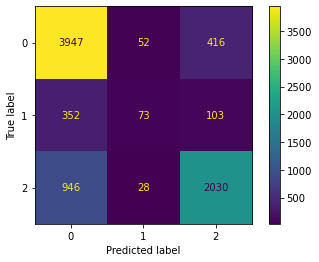

In [134]:
# plotting the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds)).plot();

In [135]:
# get the feature importances from the model
importances = dtpipe.steps[1][1].feature_importances_

In [136]:
# get the column names from the one hot encoded 
ohe_cols = dtpipe.named_steps['ct'].transformers_[1][1].named_steps['ohe'].get_feature_names()

In [137]:
# create a list of all the column names
features = list(num_cols)[1:] + list(ohe_cols)

In [138]:
# zip together the column names with the corresponding feature importances
feat_dict = dict(zip(features, importances))
# then sort the dictionary by the values in descending order
{k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}

{'x11_other': 0.19457584697891608,
 'x9_enough': 0.09584081771782849,
 'x9_seasonal': 0.09565720731486685,
 'construction_year': 0.0905302239328466,
 'longitude': 0.07784196150717129,
 'latitude': 0.07365595533802195,
 'x9_insufficient': 0.05879551272514883,
 'amount_tsh': 0.04100758545836181,
 'population': 0.036390549452408986,
 'gps_height': 0.03558203073508399,
 'x1_Iringa': 0.03227710639393942,
 'x11_communal standpipe': 0.026116837081136133,
 'x11_communal standpipe multiple': 0.017801420637771126,
 'x10_machine dbh': 0.009684144980604553,
 'x5_submersible': 0.009447022201600923,
 'x5_other': 0.007686988317372747,
 'x6_vwc': 0.006963351606410768,
 'x10_shallow well': 0.006009147216729226,
 'x5_gravity': 0.005874854594941057,
 'x3_Water Board': 0.005391570731377349,
 'x3_Water authority': 0.0052621078315316224,
 'x10_spring': 0.0043522109755251654,
 'x9_unknown': 0.004233179423955998,
 'x6_private operator': 0.0038910724752483,
 'x0_Wami / Ruvu': 0.003543372209503395,
 'x1_Ruvuma'

## Random Forest Classifier

A natural progression from the decision tree is the random forest classifier. This will be able to capture the success of our previous decision tree model as well improve upon it's results due to the nature of ensemble algorithms. Here, the accuracy of the model on testing data and cross-validation was about 81%, which is a huge improvement over the decision tree. However, The model was even worse in the overfitting department. It nearly had perfect accuracy on the training data. The model made a significant improvement in terms of correctly classifying the wells that are functional but in need of repair.

In [149]:
# create a pipeline for the random forest classifier
rfpipe = Pipeline([
    ('ct', CT),
    ('forest', RandomForestClassifier(random_state=42))
])

In [150]:
# fit the pipe
rfpipe.fit(X_train_trim, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   RobustScaler())]),
                                                  [0, 1, 2, 3, 4, 5]),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  [6, 7, 8, 9, 10, 11, 12, 13,
                                                   14, 15, 16, 17])])),
                ('forest'

In [151]:
# cross validate on the model
cross_val_score(rfpipe, X_train_trim, y_train).mean()

0.8105710240679566

In [152]:
# score the model on training data
rfpipe.score(X_train_trim, y_train)

0.9999370772376908

In [153]:
# score the model on testing data
rfpipe.score(X_test_trim, y_test)

0.8141437020259217

In [154]:
# get predictions from the model
y_preds = rfpipe.predict(X_test_trim)

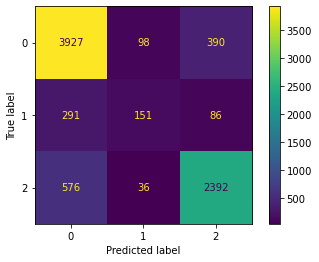

In [155]:
# plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds)).plot();

In [156]:
# get the feature importances from the model
importances = rfpipe.steps[1][1].feature_importances_

In [157]:
# get the column names from the one hot encoded 
ohe_cols = rfpipe.named_steps['ct'].transformers_[1][1].named_steps['ohe'].get_feature_names()

In [158]:
# create a list of all the column names
features = list(num_cols)[1:] + list(ohe_cols)

In [159]:
# zip together the column names with the corresponding feature importances
feat_dict = dict(zip(features, importances))
# then sort the dictionary by the values in descending order
{k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}

{'longitude': 0.12545644220505053,
 'latitude': 0.12247125733961156,
 'gps_height': 0.11089169700890249,
 'construction_year': 0.0897424159526342,
 'population': 0.07625400544891296,
 'amount_tsh': 0.04985583242377672,
 'x9_enough': 0.040914596361621654,
 'x11_other': 0.03319247910697294,
 'x5_other': 0.021440878541349573,
 'x11_communal standpipe': 0.017762096231787226,
 'x9_insufficient': 0.017046978027847458,
 'x11_communal standpipe multiple': 0.010800897785805579,
 'x5_gravity': 0.01034787990866852,
 'x4_True': 0.009990945479149744,
 'x9_seasonal': 0.009694487423371199,
 'x10_spring': 0.00951534656526553,
 'x6_vwc': 0.008935069270388446,
 'x8_soft': 0.008342756183133631,
 'x11_hand pump': 0.008163921276342287,
 'x3_VWC': 0.007970618741909338,
 'x8_unknown': 0.007136980135823986,
 'x7_pay monthly': 0.007044440203284475,
 'x1_Iringa': 0.006886870635090259,
 'x10_machine dbh': 0.006791369049251577,
 'x7_other': 0.006727502656255923,
 'x10_shallow well': 0.00655480448306211,
 'x10_riv

## Gradient Boosting Classifier

Another ensemble method that could improve upon the decision tree model is a gradient boosting classifier. It is often a good idea to try out different algorithms and see which one performs the best so that you can investigate which would be a better investment of time spent tuning hyperparameters. While it may be better to be more thourough for some projects, this heuristic will be useful here, where time is of the essence. We see that the gradient boosting classifier did significantly worse here despite being less overfit. The training, cross-validation, and testing accuracy were all about 77%. The model also had much worse performance in terms of finding the wells that were functional, but in need of repair. The model was also significantly slower than the random forest classifier. 

In [106]:
# set up a pipeline with default gradient boosting classifier
gbpipe = Pipeline([
    ('ct', CT),
    ('gb', GradientBoostingClassifier())
])

In [107]:
# fit the model to training data
gbpipe.fit(X_train_trim, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   RobustScaler())]),
                                                  [0, 1, 2, 3, 4, 5]),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  [6, 7, 8, 9, 10, 11, 12, 13,
                                                   14, 15, 16, 17])])),
                ('gb', Gr

In [90]:
# get the cross-validation score from the model
cross_val_score(gbpipe, X_train_trim, y_train).mean()

array([0.77143307, 0.76655655, 0.77316344, 0.77489382, 0.76577002])

In [91]:
# get the models accuracy on training data
gbpipe.score(X_train_trim, y_train)

0.7771904986628912

In [110]:
# models accuracy on testing data
gbpipe.score(X_test_trim, y_test)

0.7659494148735372

In [108]:
# models predictions
y_preds = gbpipe.predict(X_test_trim)

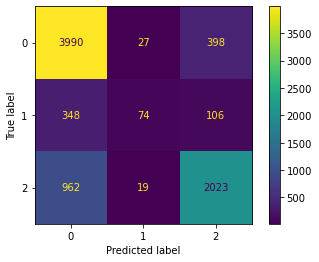

In [109]:
# plot a confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds)).plot();

In [102]:
# get the feature importances from the model
importances = gbpipe.steps[1][1].feature_importances_

In [103]:
# get the column names from the one hot encoded 
ohe_cols = gbpipe.named_steps['ct'].transformers_[1][1].named_steps['ohe'].get_feature_names()

In [104]:
# create a list of all the column names
features = list(num_cols)[1:] + list(ohe_cols)

In [105]:
# zip together the column names with the corresponding feature importances
feat_dict = dict(zip(features, importances))
# then sort the dictionary by the values in descending order
{k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}

{'x11_other': 0.15869366473322674,
 'construction_year': 0.11899387832058728,
 'x9_enough': 0.11451268704149087,
 'amount_tsh': 0.09547577775895827,
 'x9_insufficient': 0.09126585457880987,
 'longitude': 0.06157631168096087,
 'x11_communal standpipe multiple': 0.04302652256845092,
 'x5_other': 0.0386158694904442,
 'latitude': 0.03635824857037429,
 'x5_gravity': 0.0279181994042208,
 'x9_seasonal': 0.026516619208004345,
 'gps_height': 0.021356847045743223,
 'population': 0.017165772515494972,
 'x10_spring': 0.016649050255343315,
 'x11_communal standpipe': 0.01456578360648667,
 'x1_Iringa': 0.013305130572591375,
 'x10_rainwater harvesting': 0.008804071108328797,
 'x6_vwc': 0.0070924055533416646,
 'x10_lake': 0.005726925275578433,
 'x10_machine dbh': 0.005661394569115168,
 'x6_private operator': 0.005357427482933072,
 'x11_hand pump': 0.005319108001577952,
 'x5_submersible': 0.005313679658691526,
 'x1_Shinyanga': 0.0046617457120235765,
 'x3_Water Board': 0.004166916324612218,
 'x1_Tanga': 

## Random Forest Classifier w/ Grid Search

The random forest classifier was both more accurate and much faster than the gradient boosting classifier. For these reasons, it was a much better candidate for a grid search algorithm that tests out different hyperparameters for a model. Here we found that best model used 200 estimators, using gini as the splitting criterion, and using the auto argument for the amount of features in each model. The model slightly improved with these parameters, but still ended up with cross-validation and testing data accuracy of about 81%. The confusion matrix was also quite similiar to the default random forest classifier's, as expected. Improvements could be made upon this model, but there would be considerable diminishing returns in terms of time invested. 

In [111]:
# set up the grid for the different hyperparemeters we want tested
grid={
    'forest__n_estimators': [50, 100, 200],
    'forest__criterion': ['gini', 'entropy'],
    'forest__max_features': ['auto', 'sqrt']
}

In [112]:
# instantiate the grid search for the random forest classifier
gsrf = GridSearchCV(rfpipe, grid)

In [113]:
# fit the models to the training data
gsrf.fit(X_train_trim, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scale',
                                                                                          RobustScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4,
                                                                          5]),
                                                                        ('cat',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                      

In [114]:
# get the parameters of the best model
gsrf.best_params_

{'forest__criterion': 'gini',
 'forest__max_features': 'auto',
 'forest__n_estimators': 200}

In [128]:
# cross validation with best model
cross_val_score(gsrf.best_estimator_, X_train_trim, y_train).mean()

0.8113575585968225

In [129]:
# accuracy of the best model on training data
gsrf.score(X_train_trim, y_train)

1.0

In [130]:
# accuracy of the best model on testing data
gsrf.score(X_test_trim, y_test)

0.8132628664904996

In [131]:
# predictions for the best grid search estimator
y_preds = gsrf.best_estimator_.predict(X_test_trim)

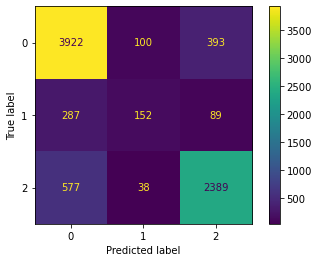

In [132]:
# confusion matrix of the best model
ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds)).plot();

In [133]:
# get the feature importances from the model
importances = gsrf.best_estimator_.steps[1][1].feature_importances_

In [134]:
# get the column names from the one hot encoded 
ohe_cols = gsrf.best_estimator_.named_steps['ct'].transformers_[1][1].named_steps['ohe'].get_feature_names()

In [135]:
# create a list of all the column names
features = list(num_cols)[1:] + list(ohe_cols)

In [136]:
# zip together the column names with the corresponding feature importances
feat_dict = dict(zip(features, importances))
# then sort the dictionary by the values in descending order
{k: v for k, v in sorted(feat_dict.items(), key=lambda item: item[1], reverse=True)}

{'longitude': 0.12494978522498539,
 'latitude': 0.12317715489890388,
 'gps_height': 0.11101020750824908,
 'construction_year': 0.08952905543903515,
 'population': 0.07639523303676123,
 'amount_tsh': 0.04973884727415426,
 'x9_enough': 0.041277354161503084,
 'x11_other': 0.03246948792538568,
 'x5_other': 0.023759936278443545,
 'x11_communal standpipe': 0.017579196169687398,
 'x9_insufficient': 0.017138644260350992,
 'x11_communal standpipe multiple': 0.010824746319491485,
 'x5_gravity': 0.01011658131614285,
 'x9_seasonal': 0.009951650568489335,
 'x4_True': 0.009919499638234987,
 'x10_spring': 0.009524358432264894,
 'x6_vwc': 0.008798786453365405,
 'x11_hand pump': 0.00835370850777759,
 'x8_soft': 0.008032627629356335,
 'x3_VWC': 0.007993903185273559,
 'x7_pay monthly': 0.00706533710289547,
 'x10_machine dbh': 0.006765535359129655,
 'x7_other': 0.006750500137226208,
 'x7_pay per bucket': 0.006615845250845148,
 'x2_True': 0.00654951177429966,
 'x8_unknown': 0.006513606984480363,
 'x1_Iring

## Visualizations

It's important to create visualizations that describe some of the findings from the model. These will signify that the data has been explored and the model is understandable, although somewhat opaque. Two of the most important features from the final model are `gps_height` and `construction_year`. Creating graphs of these will help non-technical stakeholders visualize the importance of these features.

In [161]:
# set the context to poster to create more readable visualizations
sns.set_context('poster')

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


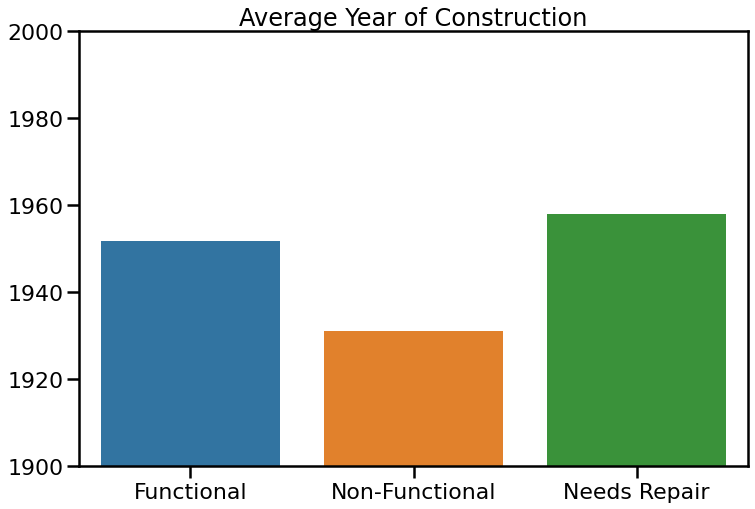

In [164]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(df_zero['status_group'], df_zero['construction_year'], ax=ax, ci=None)
ax.set_ylim(ymin=1900, ymax=2000)
ax.set_title('Average Year of Construction')
ax.set_xticklabels(['Functional', 'Non-Functional', 'Needs Repair'])
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./images/constructiongraph.png');

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


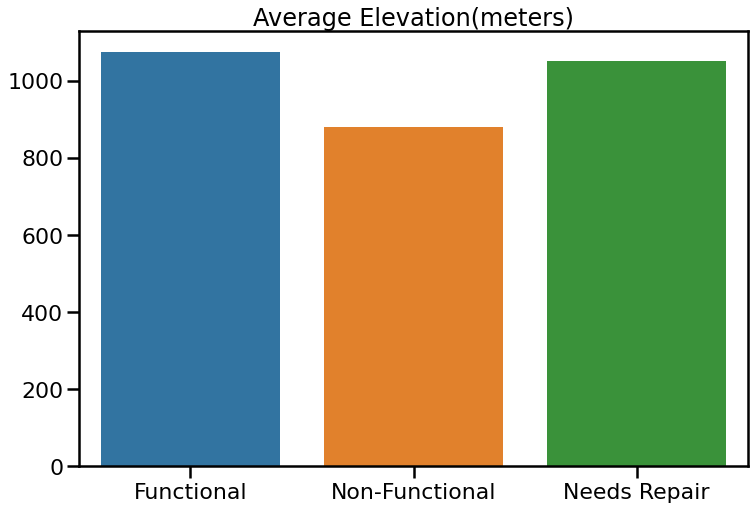

In [163]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(df_zero['status_group'], df_zero['gps_height'], ax=ax, ci=None)
ax.set_title('Average Elevation(meters)')
ax.set_xticklabels(['Functional', 'Non-Functional', 'Needs Repair'])
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./images/elevationgraph.png');

## Recommendations

## Next Steps

Mention how you had to drop the rows with all zeroes and how in the future you could improve with better data cleaning and data collection.

- One way improvement could be made is with the actual data collection. There was a severe lack of documentation on what all the different variables meant. For example, there were no units for any of the numerical variables. There was also no specific data collection methodology described. There were several points with a lot of ambiguity, especially in the `funder` and `installer` columns. Look at the cells below for examples of some of these problems.

In [ ]:
# The max depth that a SWN 80 pump is supposed to go is 40 meters
X[X['amount_tsh'] > 100][X['extraction_type_group'] == 'swn 80']

Mention how several of theses

In [ ]:
# several of these categories were entered incorrectly, 
# and many were completely ambiguous
# different entries for the Roman Catholic Church
X['funder'].replace(['Rc', 'Roman'], 'Rc Church', inplace=True)
# Jaica and Jica are alternative spellings of Japan International Cooperation Agency
X['funder'].replace('Jaica', 'Jica', inplace=True)
# Kkkt is a church in Tanzania
X['funder'].replace('Kkkt_makwale', 'Kkkt', inplace=True)
X['funder'].replace('Nethalan', 'Netherlands', inplace=True)
X['funder'].replace(['Rwssp', 'Rural Water Supply And Sanitat'], 'Rural Water Supply & Sanitation', inplace=True)
# Oxford's charity organization
X['funder'].replace('Oxfarm', 'Oxfam', inplace=True)
# Dwsp is district water and sanitation
# X['funder'].replace('Dwsp', ___)
X['funder'].replace('Mkinga Distric Coun', 'District Council', inplace=True)
X['funder'].replace('Ces (gmbh)', 'Ces(gmbh)').value_counts().head(60)

Mention some possible feature engineering

# Workbook Ramblings

### Rabbithole Thought on Zeroes

In [ ]:
nonfunct = df['status_group'] == 'non functional'

In [ ]:
((X['construction_year'] == 0) & (X['population'] == 0)).sum()

In [ ]:
((X['construction_year'] == 0) & (X['population'] == 0) & (X['amount_tsh'] == 0)).sum()

In [ ]:
((X['construction_year'] == 0) & (X['population'] == 0) & (X['amount_tsh'] == 0) & (X['gps_height'] == 0)).sum()

In [ ]:
((X['construction_year'] == 0) & (X['population'] == 0) & (X['amount_tsh'] == 0) & (X['gps_height'] == 0) & nonfunct).sum()

In [ ]:
functional = ((df['status_group'] == 'functional') | (df['status_group'] == 'functional needs repair'))

In [ ]:
((X['construction_year'] == 0) & (X['population'] == 0) & (X['amount_tsh'] == 0) & (X['gps_height'] == 0) & functional).sum()

In [ ]:
11761 / 7907

In [ ]:
functional.sum() / nonfunct.sum()

### Constuction Year

In [ ]:
(X['construction_year'] == 0).sum()

In [ ]:
# nothing below 1960, possibly bin the construction by decade
X['construction_year'].value_counts().

In [ ]:
X[X['construction_year'] == 0].head()

### Population cleaning

### Total Static Head Cleaning

In [ ]:
# almost two thirds of the data is 0, unlikely
(X['amount_tsh'] == 0).sum()

In [ ]:
# if it is surface level, it makes sense for the tsh to be zero
((X['source_class'] == 'surface') & (X['amount_tsh'] == 0)).sum()

In [ ]:
# but sometimes, even surface water doesn't have a tsh of zero
((X['source_class'] == 'surface') & (X['amount_tsh'] != 0)).sum()

In [ ]:
functional = ((df['status_group'] == 'functional') | (df['status_group'] == 'functional needs repair'))

In [ ]:
nonfunct = df['status_group'] == 'non functional'

In [ ]:
ztsh = df['amount_tsh'] == 0

In [ ]:
# while many of these probably don't make sense
df[functional & ztsh].shape

In [ ]:
# these definitely make sense
df[nonfunct & ztsh].shape

In [ ]:

X.groupby('extraction_type_group')['amount_tsh'].mean()

In [ ]:
nosh = X[X['amount_tsh'] == 0]
nosh['region'].value_counts()

In [ ]:
X['region'].value_counts()

In [ ]:
nosh['region'].value_counts()[:]/X['region'].value_counts()[:]

### Elevation

In [ ]:
X.groupby('basin')['gps_height'].mean()

In [ ]:
X.corr()

In [ ]:
X[X['gps_height'] == 0]['construction_year'].value_counts()

In [ ]:
X['construction_year'].value_counts()

In [ ]:
df[df['gps_height'] ==0]['date_recorded'].dt.month.value_counts()

In [ ]:
df['date_recorded'].dt.year.value_counts()

In [ ]:
notzero = X[X['gps_height'] != 0]

In [ ]:
notzero.groupby('ward')['gps_height'].mean()

In [ ]:
notzero.groupby('lga')['gps_height'].mean()

In [ ]:
notzero.groupby('region')['gps_height'].mean()